In [1]:


from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.2.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/erattakulangara/.conda/envs/Pytorch/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.mo

In [2]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


/tmp/tmp8bml2lp6


In [3]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)


Task09_Spleen.tar: 1.50GB [01:40, 16.0MB/s]                               

2023-09-10 08:30:28,753 - INFO - Downloaded: /tmp/tmp8bml2lp6/Task09_Spleen.tar


2023-09-10 08:30:31,078 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-09-10 08:30:31,080 - INFO - Writing into directory: /tmp/tmp8bml2lp6.


In [4]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]


In [5]:
set_determinism(seed=0)


In [6]:


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(32, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [7]:
check_ds = Dataset(data=val_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")

image shape: torch.Size([4, 1, 32, 96, 96]), label shape: torch.Size([4, 1, 32, 96, 96])


image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


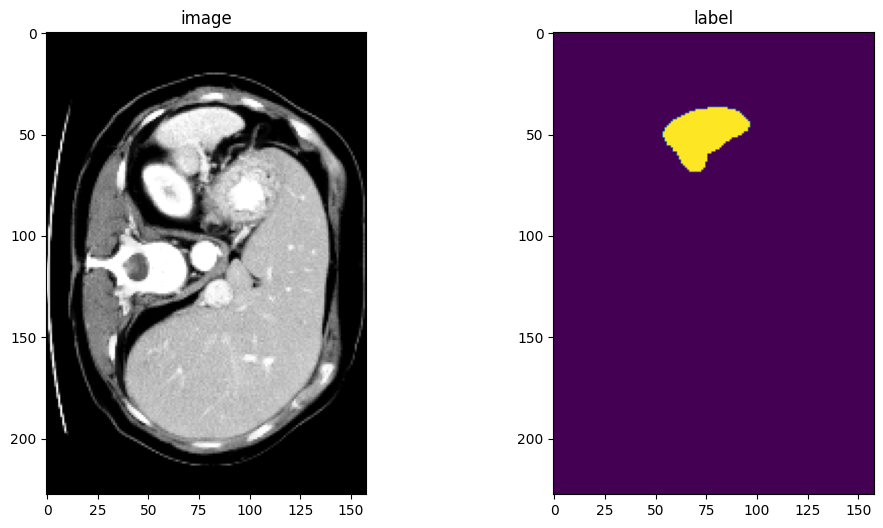

In [9]:


check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()


In [10]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)


Loading dataset: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


In [12]:


# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [13]:
max_epochs = 6
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i)
                               for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i)
                              for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


----------
epoch 1/6
torch.Size([8, 1, 32, 96, 96])
1/16, train_loss: 0.6006
torch.Size([8, 1, 32, 96, 96])
2/16, train_loss: 0.6105
torch.Size([8, 1, 32, 96, 96])
3/16, train_loss: 0.6421
torch.Size([8, 1, 32, 96, 96])
4/16, train_loss: 0.6566
torch.Size([8, 1, 32, 96, 96])
5/16, train_loss: 0.6164
torch.Size([8, 1, 32, 96, 96])
6/16, train_loss: 0.5983
torch.Size([8, 1, 32, 96, 96])
7/16, train_loss: 0.6061
torch.Size([8, 1, 32, 96, 96])
8/16, train_loss: 0.6325
torch.Size([8, 1, 32, 96, 96])
9/16, train_loss: 0.6064
torch.Size([8, 1, 32, 96, 96])
10/16, train_loss: 0.6156
torch.Size([8, 1, 32, 96, 96])
11/16, train_loss: 0.6184
torch.Size([8, 1, 32, 96, 96])
12/16, train_loss: 0.6456
torch.Size([8, 1, 32, 96, 96])
13/16, train_loss: 0.6302
torch.Size([8, 1, 32, 96, 96])
14/16, train_loss: 0.6101
torch.Size([8, 1, 32, 96, 96])
15/16, train_loss: 0.6056
torch.Size([8, 1, 32, 96, 96])
16/16, train_loss: 0.6198
epoch 1 average loss: 0.6197
----------
epoch 2/6
torch.Size([8, 1, 32, 96, 

In [14]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0616 at epoch: 6


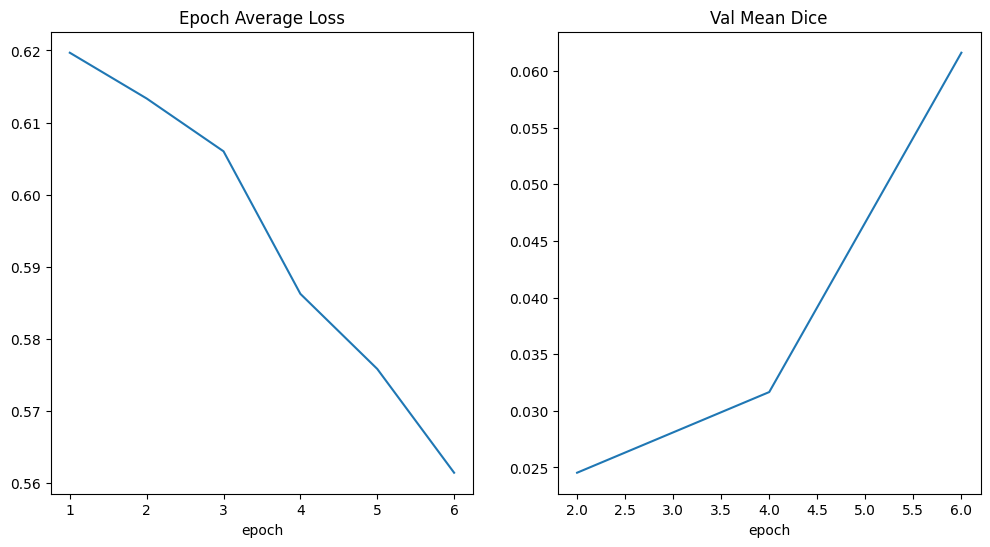

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


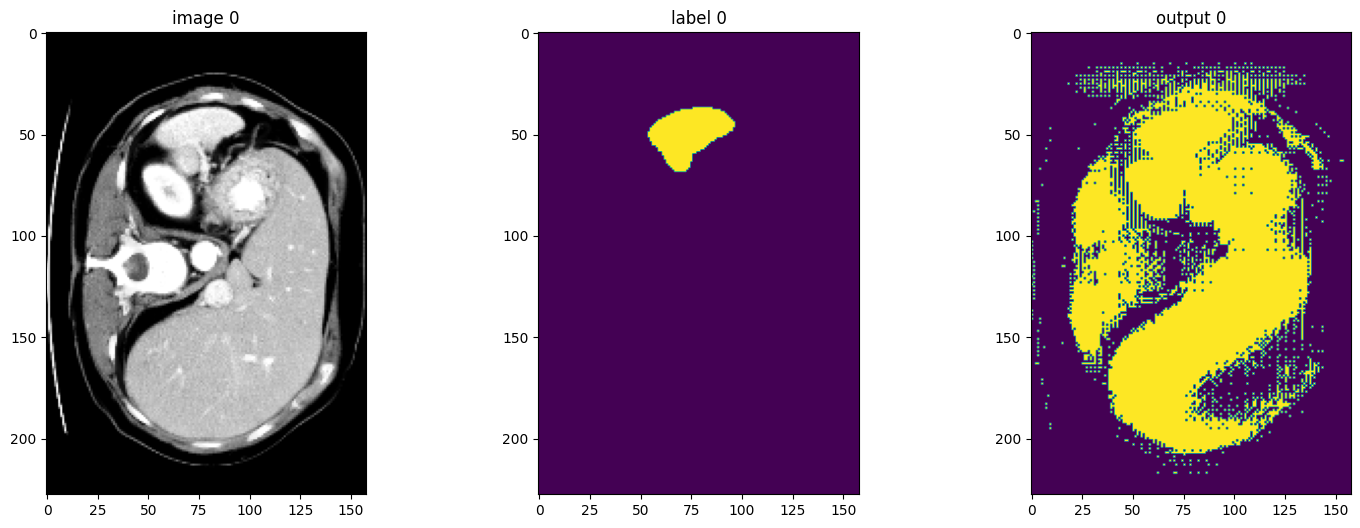

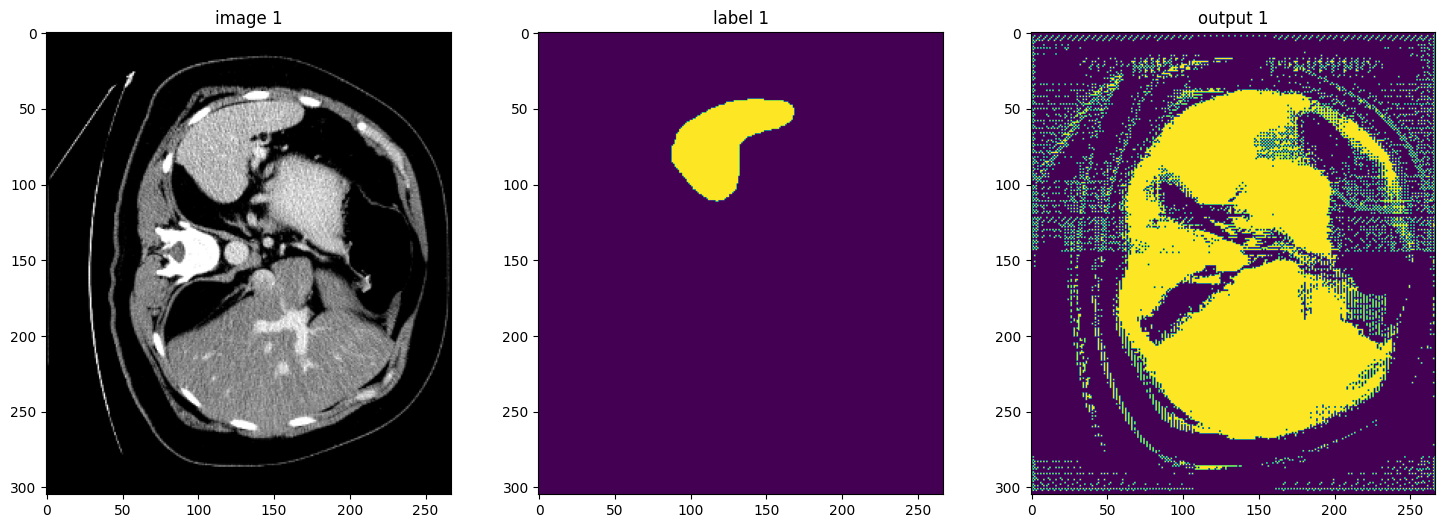

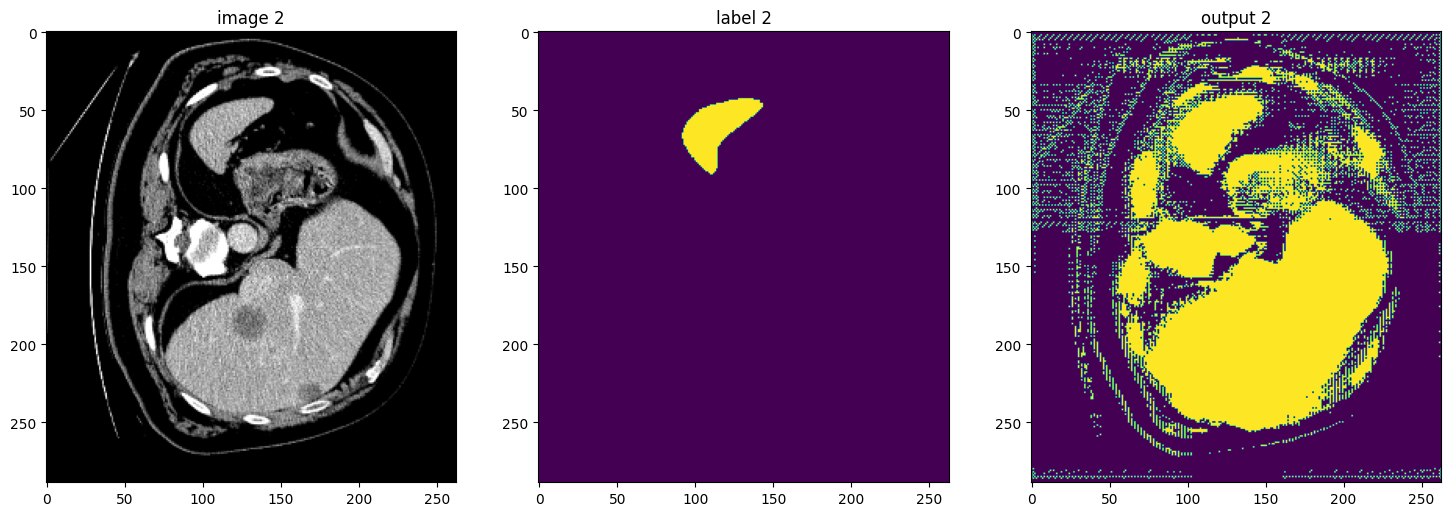

In [16]:


model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break
